In [2]:
# Configs
dataset_dir = r'datasets\extractedURLs\url_classes.csv'

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize, TweetTokenizer
import time
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv(dataset_dir)
df.dropna(inplace=True)
class_list = df.Topic.unique()
class_id = {t:i for i, t in enumerate(class_list)}
id_class = {i:t for i, t in enumerate(class_list)}
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=True)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 1024
device

device(type='cuda')

In [6]:
import re
class SepTokenizer:

    def __init__(self):
        self.splitter = re.compile(r'[/?.=-_]+')

    def __call__(self, text):
        return self.splitter.split(text)

tokenizer = SepTokenizer()
tokenizer('uk.linkedin.com/pub/steve-rubenstein/8/718/755')

['uk', 'linkedin', 'com', 'pub', 'steve-rubenstein', '8', '718', '755']

In [7]:
chars = set([c for a in df.Address.values for c in set(' '.join(tokenizer(a)))])
vocab_dict = {c:i for i, c in enumerate(chars)}

In [8]:
class CharacterandTokenLevelCustomDataset(Dataset):
    
    def __init__(self, X, y, num_classes, dictionary, tokenizer, doc_token_length=256, doc_char_length=1024) -> None:
        super().__init__()
        self.doc_char_length = doc_char_length
        self.doc_teken_length = doc_token_length
        
        
        y = torch.from_numpy(np.array([class_id[c] for c in y], dtype=np.longlong))
        self.y = torch.nn.functional.one_hot(y, num_classes=num_classes).float()
        
        self.dictionary = dictionary
        self.dict_keys = list(dictionary.keys())
        self.vocab_size = len(self.dictionary)
        self.tokenizer = tokenizer
        
        self.X = torch.zeros((len(X), self.doc_char_length), dtype=torch.long)
        # self.token_lengths = torch.zeros((len(X), self.doc_teken_length), dtype=torch.int)
        self.token_indices = torch.zeros((len(X), self.doc_char_length), dtype=torch.long)
        
        for i, doc in enumerate(X):
            tokens = self.tokenizer(doc)
            tokens.append(self.dict_keys[-1])
            doc = ' '.join(tokens)
            
            indices = torch.from_numpy(np.array([self.dictionary[t] for t in doc if t in self.dictionary], dtype=np.longlong))
            char_pad_size = max(self.doc_char_length - len(indices), 0)
            
            self.X[i] = torch.nn.functional.pad(indices[:self.doc_char_length], (0,char_pad_size))
            
            token_lengths = torch.from_numpy(np.array([len(t) for t in tokens], dtype=np.longlong))+1
            token_lengths[-1] -= 1
            token_indices = torch.repeat_interleave(torch.arange(len(token_lengths), dtype=torch.long), token_lengths)
            token_indices = torch.nn.functional.pad(token_indices[:self.doc_char_length], (0,char_pad_size), value=len(token_lengths)-1)
            self.token_indices[i] = token_indices
        
        
    def __getitem__(self, index):
        return self.X[index], self.y[index], self.token_indices[index]
        
    def __len__(self):
        return len(self.y)
        

In [9]:
train_dataset = CharacterandTokenLevelCustomDataset(df_train.Address.values, df_train.Topic.values, len(class_id), vocab_dict, tokenizer, doc_token_length=64, doc_char_length=256)
test_dataset = CharacterandTokenLevelCustomDataset(df_test.Address.values, df_test.Topic.values, len(class_id), vocab_dict, tokenizer, doc_token_length=64, doc_char_length=256)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True, shuffle=False)

In [10]:
token_lens = []
char_lens = []
dict_keys = list(vocab_dict.keys())
for doc in df.Address.values:
    tokens = tokenizer(doc)
    tokens.append(dict_keys[-1])
    doc = ' '.join(tokens)
    token_lens.append(len(tokens))
    char_lens.append(len(doc))

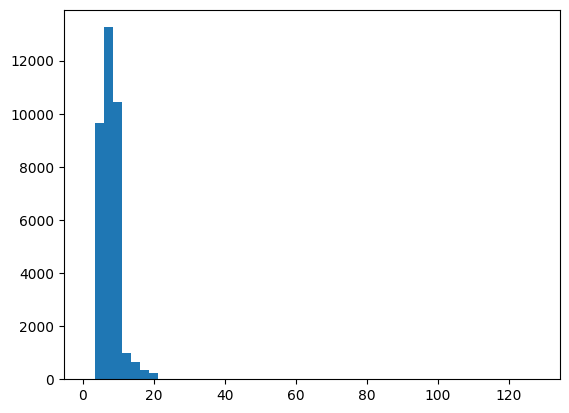

In [11]:
char_lens = np.array(char_lens)
plt.hist(token_lens, bins=50, range=(1, 128))
plt.show()

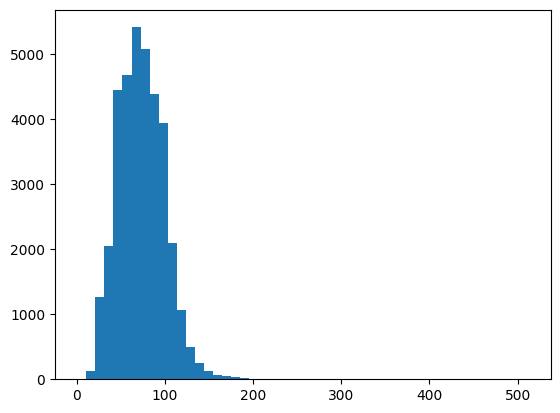

In [12]:
char_lens = np.array(char_lens)
plt.hist(char_lens, bins=50, range=(1, 512))
plt.show()

In [13]:
from torch_scatter import scatter_max, scatter_mean

In [14]:
st = time.time()
X, y, tc = next(iter(test_dataloader))
print(f'dataset time = {time.time() - st}')

dataset time = 0.024002552032470703


In [15]:
torch.max(X[1][0:9])

tensor(38)

In [16]:
tc[1][0:20]

tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [17]:
scatter_max(X,tc, dim=1)[0]

tensor([[38, 11, 48,  ...,  0,  0,  0],
        [38, 48, 21,  ...,  0,  0,  0],
        [38, 61, 21,  ...,  0,  0,  0],
        ...,
        [38, 61, 24,  ...,  0,  0,  0],
        [38, 42, 48,  ...,  0,  0,  0],
        [38, 11, 61,  ...,  0,  0,  0]])

In [18]:
class CNN_for_Text(nn.Module):
    
    def __init__(self, num_embedding, batch_size, embedding_dim=64, hidden_dim=64, dropout=0.3, num_out_features=4, kernel_size=[5, 5, 3, 3], seed=-1, *args, **kwargs) -> None:
        super(CNN_for_Text, self).__init__(*args, **kwargs)
        self.batch_size = batch_size
        if seed>-1:
            torch.manual_seed(seed)
        
        self.embedding = nn.Embedding(num_embedding, embedding_dim)
        # nn.init.normal_(self.embedding.weight)
        self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=kernel_size[0], padding=kernel_size[0]//2)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=kernel_size[1], padding=kernel_size[1]//2)
        
        # self.conv3 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(2*hidden_dim, hidden_dim, kernel_size=kernel_size[2], padding=kernel_size[2]//2)
        self.pool1 = nn.MaxPool1d(2)
        self.conv4 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=kernel_size[3], padding=kernel_size[3]//2)
        
        self.globalpool = nn.AdaptiveMaxPool1d(hidden_dim)
        self.fc1 = nn.Linear(hidden_dim * hidden_dim, 32)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(32, num_out_features)
    
    def forward(self, x, token_counts):
        x = self.embedding(x)
        x = self.dropout(x)
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        # x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = x.permute(0, 2, 1)
        x1 = scatter_max(x,token_counts, dim=1)[0]
        x2 = scatter_mean(x,token_counts, dim=1)
        # x2 = scatter_sum(x,token_counts, dim=1)
        # x2 = scatter_std(x,token_counts, dim=1)
        x = torch.cat([x1, x2], dim=2)
        # x = F.layer_norm(x, (x.shape[1], x.shape[2]))
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv3(x))
        x = self.pool1(x)
        x = F.relu(self.conv4(x))
        x = self.globalpool(x)
        x = F.elu_(self.fc1(x.view(x.shape[0], -1)))
        x = self.dropout(x)
        x = self.fc_out(x)
        return x

In [19]:
if True:
    pass
    # class CNN_for_Text(nn.Module):
    #     def __init__(self, num_embedding, batch_size, max_char_count, embedding_dim=64, hidden_dim=64, dropout=0.3, num_out_features=4, seed=-1, *args, **kwargs) -> None:
    #         super(CNN_for_Text, self).__init__(*args, **kwargs)
    #         self.batch_size = batch_size
    #         self.max_char_count = max_char_count
    #         if seed>-1:
    #             torch.manual_seed(seed)
            
    #         self.embedding = nn.Embedding(num_embedding, embedding_dim)
    #         # nn.init.normal_(self.embedding.weight)
    #         self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=5, padding=2)
    #         self.pool1 = nn.MaxPool1d(2)
    #         self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
            
    #         # self.conv3 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
    #         self.conv3 = nn.Conv1d(2*hidden_dim, hidden_dim, kernel_size=3, padding=1)
    #         self.pool1 = nn.MaxPool1d(2)
    #         self.conv4 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
            
    #         self.globalpool = nn.AdaptiveMaxPool1d(hidden_dim)
    #         self.fc1 = nn.Linear(hidden_dim * hidden_dim, 32)
    #         self.dropout = nn.Dropout(dropout)
    #         self.fc_out = nn.Linear(32, num_out_features)
        
    #     def forward(self, x, token_counts):
    #         x = self.embedding(x)
    #         x = self.dropout(x)
    #         x = x.permute(0, 2, 1)
    #         x = F.relu(self.conv1(x))
    #         # x = self.pool1(x)
    #         x = F.relu(self.conv2(x))
    #         x = self.dropout(x)
    #         x = x.permute(0, 2, 1)
    #         x1 = scatter_max(x,token_counts, dim=1)[0]
    #         x2 = scatter_mean(x,token_counts, dim=1)
    #         # x2 = scatter_sum(x,token_counts, dim=1)
    #         # x2 = scatter_std(x,token_counts, dim=1)
    #         x = torch.cat([x1, x2], dim=2)
    #         # x = F.layer_norm(x, (x.shape[1], x.shape[2]))
    #         x = x.permute(0, 2, 1)
    #         x = F.relu(self.conv3(x))
    #         x = self.pool1(x)
    #         x = F.relu(self.conv4(x))
    #         x = self.globalpool(x)
    #         x = F.elu_(self.fc1(x.view(x.shape[0], -1)))
    #         x = self.dropout(x)
    #         x = self.fc_out(x)
    #         return x

In [20]:
model = CNN_for_Text(num_embedding=len(vocab_dict), batch_size=batch_size, embedding_dim=96, num_out_features=len(class_id))

In [21]:
model(X, tc)

tensor([[ 0.1398, -0.0626,  0.1442,  ..., -0.0167, -0.1699, -0.1055],
        [ 0.1512, -0.0587,  0.1531,  ..., -0.0057, -0.1302, -0.1005],
        [ 0.1274, -0.0529,  0.1666,  ..., -0.0439, -0.1591, -0.0924],
        ...,
        [ 0.1377, -0.0484,  0.1555,  ..., -0.0324, -0.1291, -0.0901],
        [ 0.1210, -0.0791,  0.1431,  ..., -0.0472, -0.1157, -0.0762],
        [ 0.1332, -0.0643,  0.1437,  ..., -0.0341, -0.1670, -0.1032]],
       grad_fn=<AddmmBackward0>)

In [44]:
import torchmetrics
import lightning as L
# from abc import abstractmethod

In [45]:

class ClassifierLightningModel(L.LightningModule):
    def __init__(
        self,
        model,
        num_classes,
        optimizer=None,
        loss_func=None,
        learning_rate=0.01,
        batch_size=64,
        lr_scheduler=None,
        user_lr_scheduler=False,
        min_lr=0.0,
    ):
        super(ClassifierLightningModel, self).__init__()
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = model
        self.min_lr = min_lr
        # self.save_hyperparameters(ignore=["model"])
        self.save_hyperparameters("model", logger=False)
        self.optimizer = self._get_optimizer(optimizer)
        self.lr_scheduler = (
            self._get_lr_scheduler(lr_scheduler) if user_lr_scheduler else None
        )
        self.loss_func = loss_func
        self.train_losses = []
        self.val_losses = []
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x, token_count, *args, **kwargs):
        return self.model(x, token_count)

    def on_train_epoch_start(self) -> None:
        param_groups = next(iter(self.optimizer.param_groups))
        if "lr" in param_groups and param_groups["lr"] is not None:
            current_learning_rate = float(param_groups["lr"])
            self.log(
                "lr",
                current_learning_rate,
                batch_size=self.batch_size,
                on_epoch=True,
                on_step=False,
            )

    def training_step(self, batch, *args, **kwargs):
        X, y, token_count = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.train()
        y_out = self(X, token_count)

        loss = self.loss_func(y_out.view(y.shape), y )
        self.train_losses.append(loss.detach().item())
        self.log(
            "train_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        self.train_acc(torch.argmax(y_out, dim=1), torch.argmax(y, dim=1))
        self.log('train_acc', self.train_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)
        
        return loss

    def validation_step(self, batch, *args, **kwargs):
        X, y, token_count = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.eval()
        y_out = self(X, token_count)
        loss = self.loss_func(y_out.view(y.shape), y )
        self.val_losses.append(loss.detach().item())

        self.log(
            "val_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        
        self.val_acc(torch.argmax(y_out, dim=1), torch.argmax(y, dim=1))
        self.log('val_acc', self.val_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)

    def configure_optimizers(self):
        if self.lr_scheduler is None:
            return self.optimizer

        return {
            "optimizer": self.optimizer,
            "lr_scheduler": {
                "scheduler": self.lr_scheduler,
                "monitor": "train_loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }

    def update_learning_rate(self, learning_rate: float):
        self.learning_rate = learning_rate
        for g in self.optimizer.param_groups:
            g["lr"] = learning_rate

    def _get_optimizer(self, optimizer):
        return (
            optimizer
            if optimizer is not None
            else torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        )

    def _get_lr_scheduler(self, lr_scheduler):
        return (
            lr_scheduler
            if lr_scheduler is not None
            else torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer, patience=5, factor=0.5, mode="min", min_lr=self.min_lr
            )
        )


In [46]:
lr= 0.0036
output_size = 128
hidden_dim = 64
embedding_dim = 64
label_size = 1

In [47]:
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
import lightning as L

seed = 911
callbacks = [
    ModelCheckpoint(save_top_k=5, mode='max', monitor='val_acc', save_last=True)
    ]

classifier_torch_model = CNN_for_Text(num_embedding=len(vocab_dict), batch_size=batch_size, hidden_dim=hidden_dim, embedding_dim=embedding_dim, dropout=0.15, num_out_features=len(class_id), kernel_size=[5, 5, 5, 3], seed=seed).to(device)
optimizer = torch.optim.Adam(classifier_torch_model.parameters(), lr=lr, weight_decay=0.00011)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25, 50, 75, 100, 125, 150, 175],gamma=0.5)
loss_func = torch.nn.BCEWithLogitsLoss()
classfier_lightning_model = ClassifierLightningModel(classifier_torch_model, 
                                                    num_classes=len(class_id),
                                            learning_rate=lr,
                                            batch_size=batch_size,
                                            optimizer=optimizer,
                                            loss_func=loss_func,
                                            lr_scheduler=lr_scheduler,
                                            user_lr_scheduler=True
                                            ).to(device)


trainer = L.Trainer(
            callbacks=callbacks,
            max_epochs=200,
            accelerator= 'gpu' if torch.cuda.is_available() else 'cpu',
            logger=CSVLogger(save_dir='logs/', name='log2')
        )

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [48]:
trainer.fit(classfier_lightning_model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | CNN_for_Text       | 230 K 
1 | loss_func | BCEWithLogitsLoss  | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | val_acc   | MulticlassAccuracy | 0     
4 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
230 K     Trainable params
0         Non-trainable params
230 K     Total params
0.920     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:293: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [53]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from torchmetrics.classification import ConfusionMatrix
def calculate_metrics(cl_model):
    cm = ConfusionMatrix(task="multiclass", num_classes=len(class_id))

    y_pred = []
    y_true = []

    cl_model = cl_model.eval()
    cl_model.to(device)
    for X, y, tc in tqdm(test_dataloader):
        X = X.to(device)
        tc = tc.to(device)
        with torch.no_grad():
            y_p = cl_model(X, tc)
            y_p = y_p.cpu()
        y_pred.append(y_p)
        y_true.append(y)
    y_pred = torch.cat(y_pred, dim=0)
    y_true = torch.cat(y_true, dim=0)
    y_pred2 = torch.argmax(y_pred, dim=1)
    y_true2 = torch.argmax(y_true, dim=1)
    print(f'classification report: \n {classification_report(y_true2, y_pred2, digits=4)}')
    print(f'confusion matrix:\n {cm(y_pred2, y_true2)}')
    print('================================')


In [54]:
classfier_lightning_model.model = classfier_lightning_model.model.eval()
classfier_lightning_model = classfier_lightning_model.eval()
calculate_metrics(classfier_lightning_model)

100%|██████████| 3/3 [00:00<00:00, 10.31it/s]

classification report: 
               precision    recall  f1-score   support

           0     0.7401    0.7168    0.7282       286
           1     0.7962    0.8648    0.8291       244
           2     0.8932    0.8294    0.8601       252
           3     0.8458    0.7355    0.7868       276
           4     0.7592    0.6042    0.6729       240
           5     0.6752    0.6655    0.6703       278
           6     0.6817    0.7323    0.7061       269
           7     0.8828    0.8401    0.8610       269
           8     0.6206    0.6863    0.6518       255
           9     0.6510    0.8222    0.7267       270
          10     0.7227    0.7171    0.7198       258
          11     0.8144    0.7771    0.7953       175

    accuracy                         0.7484      3072
   macro avg     0.7569    0.7493    0.7507      3072
weighted avg     0.7546    0.7484    0.7491      3072

confusion matrix:
 tensor([[205,  10,   1,   0,   2,   2,   6,   3,  39,  12,   3,   3],
        [  9, 211, 

In [55]:
trainer.checkpoint_callback.best_model_path

'logs/log2\\version_119\\checkpoints\\epoch=137-step=4278.ckpt'

In [56]:
classifier_torch_model = CNN_for_Text(num_embedding=len(vocab_dict), batch_size=batch_size, hidden_dim=hidden_dim, embedding_dim=embedding_dim, max_char_count=256, dropout=0.15, num_out_features=len(class_id), kernel_size=[5, 5, 5, 3], seed=seed).to(device)
best_model_path = rf'{trainer.checkpoint_callback.best_model_path}' 
# best_model_path = r'logs\log2\version_102\checkpoints\epoch=187-step=7332.ckpt'
lightning_model = ClassifierLightningModel.load_from_checkpoint(best_model_path, map_location=None, hparams_file=None, strict=True, model=classifier_torch_model, num_classes=len(class_id)).eval()

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [57]:
calculate_metrics(lightning_model)

100%|██████████| 3/3 [00:00<00:00, 11.20it/s]

classification report: 
               precision    recall  f1-score   support

           0     0.7707    0.7168    0.7428       286
           1     0.7955    0.8607    0.8268       244
           2     0.8932    0.8294    0.8601       252
           3     0.8443    0.7464    0.7923       276
           4     0.7680    0.6208    0.6866       240
           5     0.6507    0.6835    0.6667       278
           6     0.7164    0.7138    0.7151       269
           7     0.8764    0.8439    0.8598       269
           8     0.6215    0.7020    0.6593       255
           9     0.6311    0.8111    0.7099       270
          10     0.7371    0.7171    0.7269       258
          11     0.8303    0.7829    0.8059       175

    accuracy                         0.7513      3072
   macro avg     0.7613    0.7523    0.7543      3072
weighted avg     0.7587    0.7513    0.7525      3072

confusion matrix:
 tensor([[205,  11,   1,   0,   5,   2,   5,   3,  38,  11,   2,   3],
        [  5, 210, 

In [58]:
p = 0.7613    
r = 0.7523    
(2*p*r)/(p+r)

0.7567732426004228